In [10]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# Load and preprocess data
file_paths = {
    "TCB": "financial_data_TCB_filtered.csv",
    "VCB": "financial_data_VCB_filtered.csv",
    "BID": "financial_data_BID_filtered.csv",
    "MBB": "financial_data_MBB_filtered.csv",
    "GDP": "gdp_quarterly_2013_2023.csv"
}

# Read each file
data_tcb = pd.read_csv(file_paths["TCB"])
data_vcb = pd.read_csv(file_paths["VCB"])
data_bid = pd.read_csv(file_paths["BID"])
data_mbb = pd.read_csv(file_paths["MBB"])
data_gdp = pd.read_csv(file_paths["GDP"])

# Convert 'Date' columns to datetime format for each dataset
data_tcb['Date'] = pd.to_datetime(data_tcb['Date'])
data_vcb['Date'] = pd.to_datetime(data_vcb['Date'])
data_bid['Date'] = pd.to_datetime(data_bid['Date'])
data_mbb['Date'] = pd.to_datetime(data_mbb['Date'])
data_gdp['Date'] = pd.to_datetime(data_gdp['Date'])


In [12]:
# Merge the bank data with GDP data based on the 'Date' column
merged_data = data_gdp.copy()
merged_data = merged_data.merge(data_tcb, on="Date", suffixes=('', '_TCB'))
merged_data = merged_data.merge(data_vcb, on="Date", suffixes=('', '_VCB'))
merged_data = merged_data.merge(data_bid, on="Date", suffixes=('', '_BID'))
merged_data = merged_data.merge(data_mbb, on="Date", suffixes=('', '_MBB'))


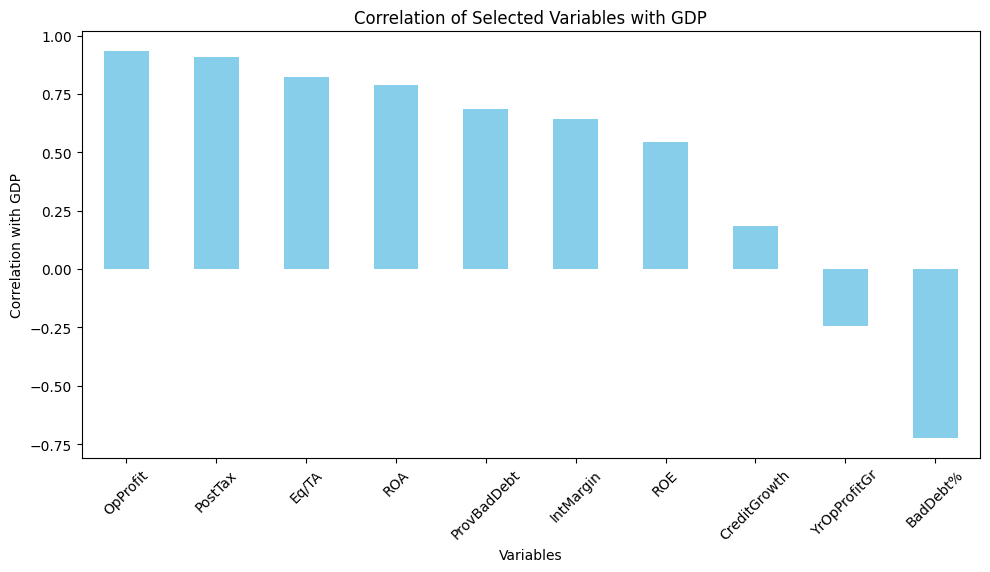

In [13]:
# Select only the relevant columns for independent variables
selected_features = [
    'roe', 'roa', 'interestMargin', 'badDebtPercentage', 'creditGrowth', 
    'operationProfit', 'yearOperationProfitGrowth', 'postTaxProfit', 
    'provisionOnBadDebt', 'equityOnTotalAsset'
]
filtered_data = merged_data[["Quarterly_GDP"] + selected_features]

# Calculate correlation between GDP and selected independent variables
correlation_selected = filtered_data.corr()
gdp_correlation_selected = correlation_selected["Quarterly_GDP"].sort_values(ascending=False)

# Map for abbreviated names
abbreviations = {
    'operationProfit': 'OpProfit', 
    'postTaxProfit': 'PostTax', 
    'equityOnTotalAsset': 'Eq/TA',
    'roa': 'ROA', 
    'provisionOnBadDebt': 'ProvBadDebt',
    'interestMargin': 'IntMargin', 
    'roe': 'ROE', 
    'creditGrowth': 'CreditGrowth', 
    'yearOperationProfitGrowth': 'YrOpProfitGr', 
    'badDebtPercentage': 'BadDebt%'
}

# Replace index with abbreviations for easier display
gdp_correlation_selected_renamed = gdp_correlation_selected.drop("Quarterly_GDP").rename(index=abbreviations)

# Plot correlation bar chart
plt.figure(figsize=(10, 6))
gdp_correlation_selected_renamed.plot(kind='bar', color='skyblue')
plt.title("Correlation of Selected Variables with GDP")
plt.xlabel("Variables")
plt.ylabel("Correlation with GDP")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [14]:
# Filter data for training and forecast
train_data = merged_data[merged_data["Date"] < "2022-01-01"]
forecast_steps = 32  # Forecast 8 years (2015 to 2030, quarterly)

# Prepare exogenous and target variables for SARIMAX
X_train_selected = train_data[selected_features].select_dtypes(include=[np.number])
y_train = train_data["Quarterly_GDP"]

# Define and train SARIMAX model
sarimax_model = SARIMAX(y_train, exog=X_train_selected, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
sarimax_fit = sarimax_model.fit(disp=False)

# Prepare future exogenous data for the forecast period
last_known_exog_selected = X_train_selected.iloc[-1]
future_exog_selected = pd.DataFrame([last_known_exog_selected] * forecast_steps, columns=X_train_selected.columns)

# Generate dates for forecast period
last_date = train_data["Date"].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')
future_exog_selected.index = future_dates

# Forecast GDP from 2022 to 2030
forecast_gdp_selected = sarimax_fit.predict(start=len(y_train), end=len(y_train) + forecast_steps - 1, exog=future_exog_selected)

# Combine actual and forecasted data for plotting
train_data_reset = train_data.reset_index(drop=True)
future_dates_series = pd.Series(future_dates)

forecast_df_selected = pd.DataFrame({
    'Date': pd.concat([train_data_reset["Date"], future_dates_series], ignore_index=True),
    'GDP': pd.concat([y_train.reset_index(drop=True), forecast_gdp_selected.reset_index(drop=True)], ignore_index=True)
}).set_index('Date')


c:\Users\Hii\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Hii\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Hii\AppData\Local\Temp\ipykernel_18788\3030781512.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')


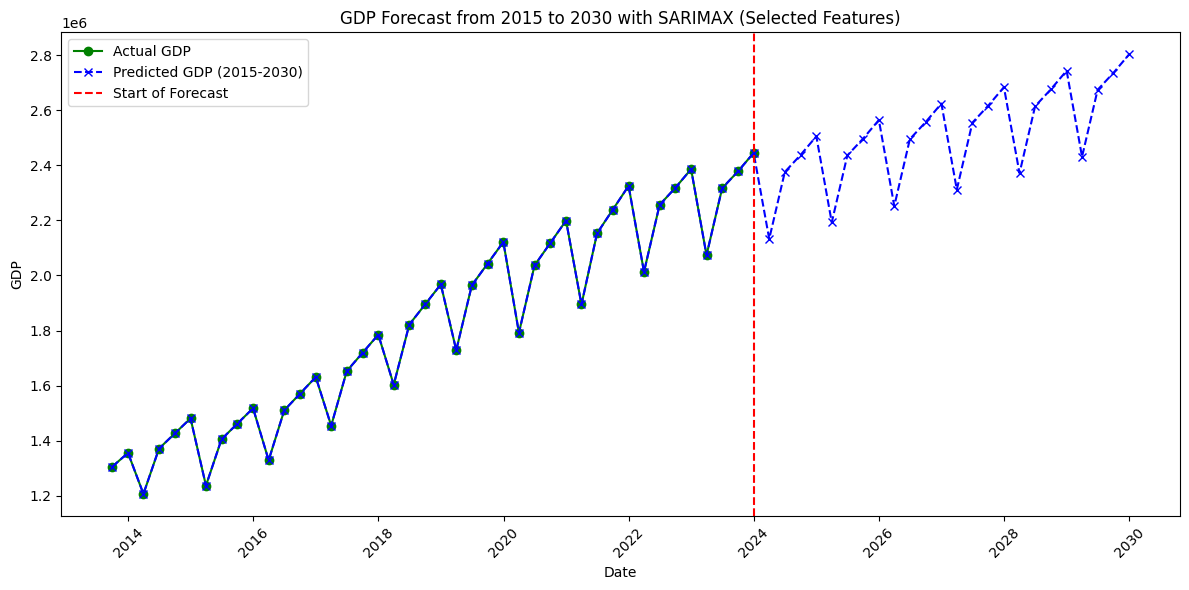

In [20]:
# Plot the forecast of GDP growth from 2015 to 2030, including the entire prediction line
plt.figure(figsize=(12, 6))

# Plot actual GDP data for 2015-2023
plt.plot(forecast_df_selected.index[forecast_df_selected.index <= '2023-12-31'], 
         forecast_df_selected['GDP'][forecast_df_selected.index <= '2023-12-31'], 
         label='Actual GDP', color='green', marker='o')

# Plot predicted GDP data for the entire period (2015-2030)
plt.plot(forecast_df_selected.index, 
         forecast_df_selected['GDP'], 
         label='Predicted GDP (2015-2030)', color='blue', linestyle='--', marker='x')

# Add a vertical line to indicate the start of the forecast period in 2024
plt.axvline(x=pd.Timestamp('2024-01-01'), color='red', linestyle='--', label='Start of Forecast')

plt.title("GDP Forecast from 2015 to 2030 with SARIMAX (Selected Features)")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


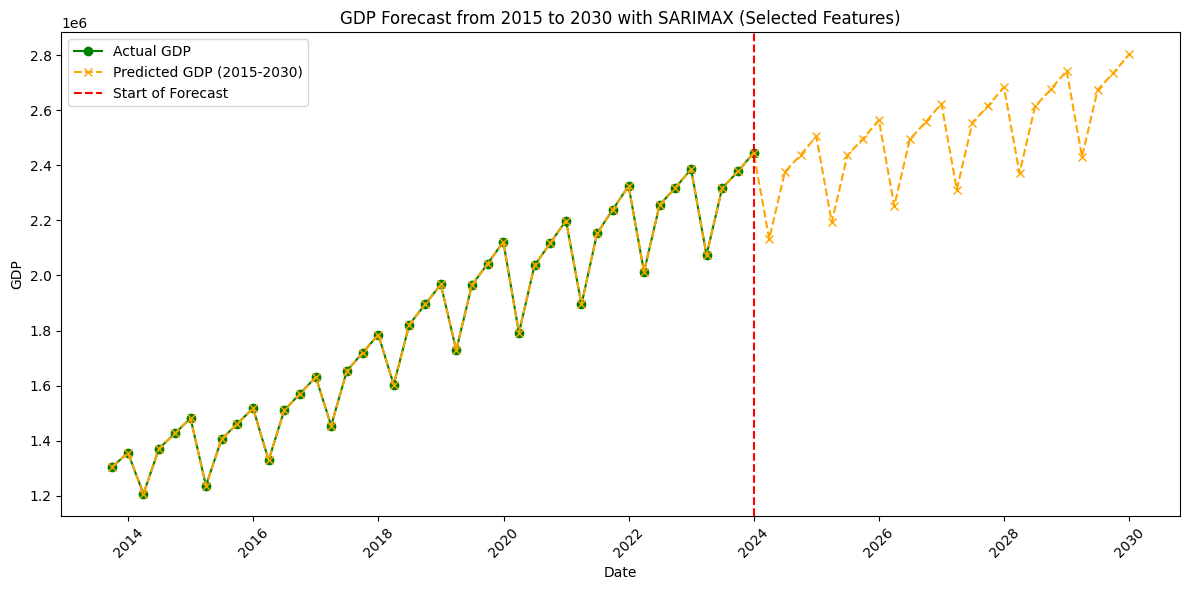

In [26]:
# Plot the forecast of GDP growth from 2015 to 2030, including the entire prediction line
plt.figure(figsize=(12, 6))

# Plot actual GDP data for 2015-2023
plt.plot(forecast_df_selected.index[forecast_df_selected.index <= '2023-12-31'], 
         forecast_df_selected['GDP'][forecast_df_selected.index <= '2023-12-31'], 
         label='Actual GDP', color='green', marker='o')

# Plot predicted GDP data for the entire period (2015-2030)
plt.plot(forecast_df_selected.index, 
         forecast_df_selected['GDP'], 
         label='Predicted GDP (2015-2030)', color='orange', linestyle='--', marker='x')

# Add a vertical line to indicate the start of the forecast period in 2024
plt.axvline(x=pd.Timestamp('2024-01-01'), color='red', linestyle='--', label='Start of Forecast')

plt.title("GDP Forecast from 2015 to 2030 with SARIMAX (Selected Features)")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Lọc khoảng dữ liệu kiểm tra từ 2020 đến 2023
test_data = merged_data[(merged_data["Date"] >= "2020-01-01") & (merged_data["Date"] <= "2023-12-31")]
X_test_selected = test_data[selected_features].select_dtypes(include=[np.number])
y_test = test_data["Quarterly_GDP"]

# Dự đoán GDP cho giai đoạn kiểm tra từ 2020 đến 2023
predicted_gdp_test = sarimax_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_selected)

# Tính MAPE
mape = mean_absolute_percentage_error(y_test, predicted_gdp_test) * 100  # Tỷ lệ phần trăm
print(f"MAPE: {mape:.2f}%")

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted_gdp_test))
print(f"RMSE: {rmse:.2f}")


MAPE: 4.93%
RMSE: 120669.52
